# Introduction to the project

The data consists of eye tracking records of 50 Danish individuals. There are a total of 26 columns for every user with various measurements (PDF file will be attached to explain each column). These individuals were tasked with reading simple childrens text in Danish. All of the individuals suffer from reading impairment conditions.

The goal of the project is to come up with features from the dataset can possibly predict whether an individual will read word incorrectly or not. An annotator was sitting with every individual during recordings, marking whether a word was read outloud incorrectly or not. The column 'marked_misread' indicates whether it was misread or not, where TRUE represents the word being misread.

The project starts with pre-processing the dataset so it is viable to make predictions.
Then you have to come up with features which can be used for predicitons (feature engineering).
Followed by descriptive statistics, such as mean of misreadings per user and so on.
Lastly, you will have to make predictions/classification (and try some parameter tuning) with algorithms that you think make sense for the analysis.

Please be creative, and comment on all the steps involved. As in, what the code does and why you implement it in that manner. Also read carefully the description for each column so you understand what it means

# Reading in the dataset

In [0]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import glob
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import os
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

C:\Users\dvargas\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [0]:
#Assigning the columns so that you can get an overview of how the dataset looks like
cols = ['user','book', 'session', 'hit_type', 'start_time', 'end_time', 'cluster_count', 'x_cord', 'y_cord', 'x_rel', 
        'y_rel', 'right_pupil', 'left_pupil', 'word_index', 'char_index', 'raw_word', 'clean_word', 'marked_misread', 
        'any_misread', 'hit_target_x_cord', 'hit_target_y_cord', 'hit_target_width', 'hit_target_heigth', 'reader_survey_type', 
        'reader_survey_answer', 'reader_survey_time']

# Task 1 - Merging all 50 csv files together in one

Here we merge all CSV files together in one

In [0]:
#Insert code here to merge all 50 csv files together in one big csv file
import glob

csv = glob.glob("*.csv")
df_list = []
for filename in csv:
    df_list.append(pd.read_csv(filename, sep=";", header = None))
    
data = pd.concat(df_list)
data = pd.DataFrame(data)
data.columns = cols

print('Raw data dimensions:', data.shape)

Raw data dimensions: (172626, 26)


In [0]:
data.head()

,user,book,session,hit_type,start_time,end_time,cluster_count,x_cord,y_cord,x_rel,...,clean_word,marked_misread,any_misread,hit_target_x_cord,hit_target_y_cord,hit_target_width,hit_target_heigth,reader_survey_type,reader_survey_answer,reader_survey_time
0,0,7,37,0,1.002900,1.045895,5,707.0424,376.5489,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,8.56014
1,0,7,37,2,1.056894,1.056894,1,862.2639,379.2451,0.232749,...,NaN,NaN,NaN,773.496,76.8,381.388,560.64,1.0,3.0,8.56014
2,0,7,37,2,1.069893,1.069893,1,898.8802,381.2875,0.328758,...,NaN,NaN,NaN,773.496,76.8,381.388,560.64,1.0,3.0,8.56014
3,0,7,37,2,1.079892,1.345865,25,969.6860,374.5526,0.514411,...,NaN,NaN,NaN,773.496,76.8,381.388,560.64,1.0,3.0,8.56014
4,0,7,37,2,1.356864,1.356864,1,889.8749,292.2946,0.305146,...,NaN,NaN,NaN,773.496,76.8,381.388,560.64,1.0,3.0,8.56014


# Task 2 - Two or more different conditions for the dataset

Condition one; Limit the dataset to rows where only a word is being looked at (see the column "hit_type"). That means that each row represents one fixation.

In [0]:
#This can be done for example by..
datahitword = data[data['hit_type'] == 1]
print('Hit type 1 data dimensions:', datahitword.shape)

Hit type 1 data dimensions: (111424, 26)


In [0]:
datahitword.head()

,user,book,session,hit_type,start_time,end_time,cluster_count,x_cord,y_cord,x_rel,...,clean_word,marked_misread,any_misread,hit_target_x_cord,hit_target_y_cord,hit_target_width,hit_target_heigth,reader_survey_type,reader_survey_answer,reader_survey_time
239,0,7,37,1,37.83222,37.99920,16,459.7513,570.2535,0.502190,...,bor,False,True,404.41,560.64,110.20,76.93,1.0,3.0,8.56014
240,0,7,37,1,38.01120,38.01120,1,412.3144,581.8342,0.071728,...,bor,False,True,404.41,560.64,110.20,76.93,1.0,3.0,8.56014
241,0,7,37,1,38.02020,38.02020,1,292.3490,597.8555,0.983140,...,fluen,False,True,136.60,560.64,158.42,76.93,1.0,3.0,8.56014
242,0,7,37,1,38.03120,38.59814,52,205.4629,582.2582,0.434686,...,fluen,False,True,136.60,560.64,158.42,76.93,1.0,3.0,8.56014
243,0,7,37,1,38.60814,38.62014,2,223.1730,559.4192,0.407115,...,køkken,False,True,136.60,483.71,212.65,76.93,1.0,3.0,8.56014


During the exploration of the raw data it was noticed that some values had an innappropriate formating (consecutive double quotes) that would add unnecessary noise to the analysis. The 'any_misread' column contained boolean, numeric and string values; as per below.

In [0]:
datahitword.any_misread.unique()

array([True, False, 'True', '431.16', '417.65', '299.81', 'False',
       '431.46', '346.69', '453.27', '235.65', '335.04', '136.6', '223.11',
       '467.84', '460.86', '224.46', '412.74', '472.47', '285.1', '462.95',
       '259', '379.29', '447.28', '436', '319.16', '424.65', '366.76',
       '307.45', '429.98', '523.87', '475.29', '308.59', '282.82', '465.8',
       '449.28', '391.74', '428.3', '229.99', '503.91', '378.12', '330.48',
       '486.58', '242.11', '509.98', '484.37', '529.74', '223.44',
       '480.66', '399.95', '429.27', '436.01', '409.01', '418.37',
       '355.89', '276.86', '264.95', '450.38', '415.73', '245.74',
       '503.89', '254.78', '323.67', '174.67', '311.03', '406.54',
       '436.69', '494.11', '474.32', '456.02', '396.28', '196.33',
       '444.72', '513.3', '325.44', '222.3', '426.75', '416.77', '320.37',
       '424', '414.78', '470.71', '364.64'], dtype=object)

These records were removed from the dataset.

In [0]:
pd.options.mode.chained_assignment = None

# Converting strings to booleans and dismissing numeric records
df1 = datahitword[datahitword['any_misread'] == True]
df2 = datahitword[datahitword['any_misread'] == False]
df3 = datahitword[datahitword['any_misread'] == 'True']
df3['any_misread'] = 1
df3['any_misread'] = df3['any_misread'].astype(bool)
df4 = datahitword[datahitword['any_misread'] == 'False']
df4['any_misread'] = 0
df4['any_misread'] = df4['any_misread'].astype(bool)
frames = [df1, df2, df3, df4]
datahitword = pd.concat(frames)

print('Cleaned data dimensions:', datahitword.shape)
print('Unique values of any_misread:', datahitword.any_misread.unique())

Cleaned data dimensions: (109807, 36)
Unique values of any_misread: [True False]


The *is_dupes* column was added, as a feature, to identify the words that are repeated consequently. This shows if a word was fixated for long.

In [0]:
#Function to count if a word is repeated in a sequence

is_dupes = []
uniques = set()

for e in datahitword['clean_word']:
    if e in uniques:
        is_dupes.append('1')
    else:
        is_dupes.append('0')
        uniques.add(e)
datahitword['is_dupes'] = is_dupes

print('Cleaned dimensions:', datahitword.shape)

Cleaned dimensions: (109807, 27)


The dataset contains a 1,763 unique words.

In [0]:
print('Total unique words in the dataset:', datahitword.clean_word.nunique())

Total unique words in the dataset: 1764
Total unique tags in the dataset: 29


# Task 3. Feature engineering

We will come up with features which can be used to improve the prediction of whether a word was misread or not. The goal is to try and yield the best accuracy possible and extract every possible insight possible from the dataset.

First fixation duration is the duration (*end_time* - *start_time*) first time "word_index" occurs for that specific "user" and specific "book".

In [0]:
# First duration
datahitword['first_duration'] = datahitword['end_time'] - datahitword['start_time']
datahitword['word_len'] = datahitword['clean_word'].str.len()

print('Cleaned dimensions:', datahitword.shape)
datahitword.head()

Cleaned dimensions: (109807, 29)


,user,book,session,hit_type,start_time,end_time,cluster_count,x_cord,y_cord,x_rel,...,hit_target_x_cord,hit_target_y_cord,hit_target_width,hit_target_heigth,reader_survey_type,reader_survey_answer,reader_survey_time,is_dupes,first_duration,word_len
239,0,7,37,1,37.83222,37.99920,16,459.7513,570.2535,0.502190,...,404.41,560.64,110.20,76.93,1.0,3.0,8.56014,0,0.16698,3.0
240,0,7,37,1,38.01120,38.01120,1,412.3144,581.8342,0.071728,...,404.41,560.64,110.20,76.93,1.0,3.0,8.56014,1,0.00000,3.0
241,0,7,37,1,38.02020,38.02020,1,292.3490,597.8555,0.983140,...,136.60,560.64,158.42,76.93,1.0,3.0,8.56014,0,0.00000,5.0
242,0,7,37,1,38.03120,38.59814,52,205.4629,582.2582,0.434686,...,136.60,560.64,158.42,76.93,1.0,3.0,8.56014,1,0.56694,5.0
243,0,7,37,1,38.60814,38.62014,2,223.1730,559.4192,0.407115,...,136.60,483.71,212.65,76.93,1.0,3.0,8.56014,0,0.01200,6.0


Stage 6 - No gaze.

Length of word: Length (number of characters) of the word. len(word)

Frequency of word: How often that word occurs in the whole corpus, irrelevant of "book" and "user". You have to come up with a background corpus. A common choice is Wikipedia, and build a standard language model (unigram frequencies).
So the column would be a metric for how common that word is in the danish vocabulary.

POS tagging: Find a good part of speech tagger for danish (which has good accuracy) and apply that to the "clean_word" column.

- The word length was calculated by counting how many letters does each word have
- The word frequency was calculated based on the counts of each word in the whole dataset (the individual tokens are taken from the whole dataset as a corpus)
- The POS tagging was performed with the NLTK library per word

In [0]:
#Insert code to compute features for stage 6.

#Word length
datahitword['word_len'] = datahitword['clean_word'].str.len()
datahitword.head()

# Word frequency
word_freq = pd.DataFrame(datahitword['clean_word'].value_counts())
word_freq['word'] = word_freq.index
word_freq.columns = ['count', 'clean_word']
word_freq['freq'] = word_freq['count'] / sum(word_freq['count'])
datahitword = pd.merge(datahitword, word_freq, on = 'clean_word', how = 'left')

#POS tagging
datahitword['clean_word'] = datahitword['clean_word'].astype(str)
datahitword['pos_tag'] = nltk.pos_tag(datahitword['clean_word'])
datahitword['word_tag'], datahitword['tag'] = zip(*datahitword['pos_tag'])

print('Cleaned dimensions:', datahitword.shape)
datahitword.head()

Total unique tags in the dataset: 29
Cleaned dimensions: (109807, 38)


,user,book,session,hit_type,start_time,end_time,cluster_count,x_cord,y_cord,x_rel,...,word_len,count_x,freq_x,pos_tag,count_y,freq_y,word_tag,tag,count,freq
0,0,7,37,1,37.83222,37.99920,16,459.7513,570.2535,0.502190,...,3,294.0,0.002680,"(bor, NN)",294,0.002677,bor,NN,294,0.002677
1,0,7,37,1,38.01120,38.01120,1,412.3144,581.8342,0.071728,...,3,294.0,0.002680,"(bor, NN)",294,0.002677,bor,NN,294,0.002677
2,0,7,37,1,38.02020,38.02020,1,292.3490,597.8555,0.983140,...,5,32.0,0.000292,"(fluen, NN)",32,0.000291,fluen,NN,32,0.000291
3,0,7,37,1,38.03120,38.59814,52,205.4629,582.2582,0.434686,...,5,32.0,0.000292,"(fluen, NN)",32,0.000291,fluen,NN,32,0.000291
4,0,7,37,1,38.60814,38.62014,2,223.1730,559.4192,0.407115,...,6,79.0,0.000720,"(køkken, VBN)",79,0.000719,køkken,VBN,79,0.000719


The dataset contains a 29 unique tags.

In [0]:
print('Total unique tags in the dataset:', datahitword.tag.nunique())

Total unique tags in the dataset: 29


The data was 'cleaned-up' to represent only the significant features for modeling

In [0]:
#Dropping non-features variables
datafinal = datahitword.drop(['user', 'book', 'session', 'hit_type', 'cluster_count', 'char_index', 'reader_survey_type', 
                                'reader_survey_answer', 'reader_survey_time', 'count', 'raw_word'], axis = 1)

#NaN values to blank (python machine learning models only support numeric inputs)
datafinal = datafinal.dropna(axis = 0)

print('Cleaned dimensions:', datafinal.shape)
datafinal.head()

Cleaned dimensions: (94095, 27)


,start_time,end_time,x_cord,y_cord,x_rel,y_rel,right_pupil,left_pupil,word_index,clean_word,...,first_duration,word_len,count_x,freq_x,pos_tag,count_y,freq_y,word_tag,tag,freq
0,37.83222,37.99920,459.7513,570.2535,0.502190,0.126654,4.203149,3.987437,2.0,bor,...,0.16698,3,294.0,0.002680,"(bor, NN)",294,0.002677,bor,NN,0.002677
1,38.01120,38.01120,412.3144,581.8342,0.071728,0.277190,4.231262,4.037369,2.0,bor,...,0.00000,3,294.0,0.002680,"(bor, NN)",294,0.002677,bor,NN,0.002677
2,38.02020,38.02020,292.3490,597.8555,0.983140,0.485447,4.231110,4.034607,0.0,fluen,...,0.00000,5,32.0,0.000292,"(fluen, NN)",32,0.000291,fluen,NN,0.000291
3,38.03120,38.59814,205.4629,582.2582,0.434686,0.282702,4.170442,4.049124,0.0,fluen,...,0.56694,5,32.0,0.000292,"(fluen, NN)",32,0.000291,fluen,NN,0.000291
4,38.60814,38.62014,223.1730,559.4192,0.407115,0.985820,4.172119,4.053078,5.0,køkken,...,0.01200,6,79.0,0.000720,"(køkken, VBN)",79,0.000719,køkken,VBN,0.000719


To apply machine learning algorithms with the **sklearn** library, features (specifically non-numeric ones) must be encoded.

In [0]:
#Encoding features for mnodeling
le_X9 = LabelEncoder()
le_X20 = LabelEncoder()
datafinal['clean_word'] = le_X9.fit_transform(datafinal['clean_word'])
datafinal['tag'] = le_X20.fit_transform(datafinal['tag'])

print('Cleaned dimensions:', datafinal.shape)
datafinal.head()

Cleaned dimensions: (94095, 27)


,start_time,end_time,x_cord,y_cord,x_rel,y_rel,right_pupil,left_pupil,word_index,clean_word,...,first_duration,word_len,count_x,freq_x,pos_tag,count_y,freq_y,word_tag,tag,freq
0,37.83222,37.99920,459.7513,570.2535,0.502190,0.126654,4.203149,3.987437,2.0,130,...,0.16698,3,294.0,0.002680,"(bor, NN)",294,0.002677,bor,10,0.002677
1,38.01120,38.01120,412.3144,581.8342,0.071728,0.277190,4.231262,4.037369,2.0,130,...,0.00000,3,294.0,0.002680,"(bor, NN)",294,0.002677,bor,10,0.002677
2,38.02020,38.02020,292.3490,597.8555,0.983140,0.485447,4.231110,4.034607,0.0,332,...,0.00000,5,32.0,0.000292,"(fluen, NN)",32,0.000291,fluen,10,0.000291
3,38.03120,38.59814,205.4629,582.2582,0.434686,0.282702,4.170442,4.049124,0.0,332,...,0.56694,5,32.0,0.000292,"(fluen, NN)",32,0.000291,fluen,10,0.000291
4,38.60814,38.62014,223.1730,559.4192,0.407115,0.985820,4.172119,4.053078,5.0,734,...,0.01200,6,79.0,0.000720,"(køkken, VBN)",79,0.000719,køkken,23,0.000719


# Task 4 - Descriptive statistics

This section informs the reader how the important values are distributed for the dataset.

The dataset is **flawed** because there is a big disbalance between users in regards to the **marked_misread** column values.
Below there's a visual representation of this misbalance.

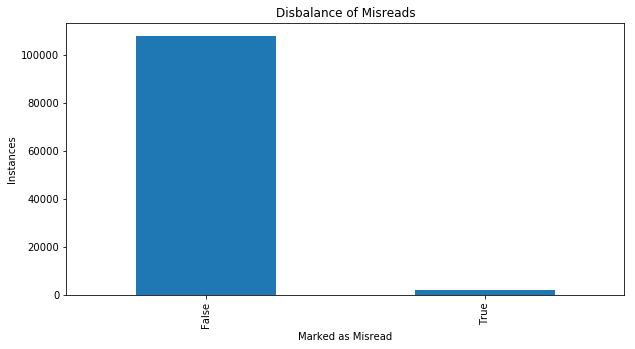

In [0]:
#Insert bunch of graphs, tables and statistic here which makes sense.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

disbalance = datahitword.groupby('marked_misread').count()

y = disbalance['user']
y.plot.bar()

plt.xlabel("Marked as Misread")
plt.ylabel("Instances")
plt.title("Disbalance of Misreads")
plt.show()

The Pearson correlation matrix provides a visual representation of the correlations between the features, but it is not to be used as a final decisions regarding features because it only shows linear correlations.

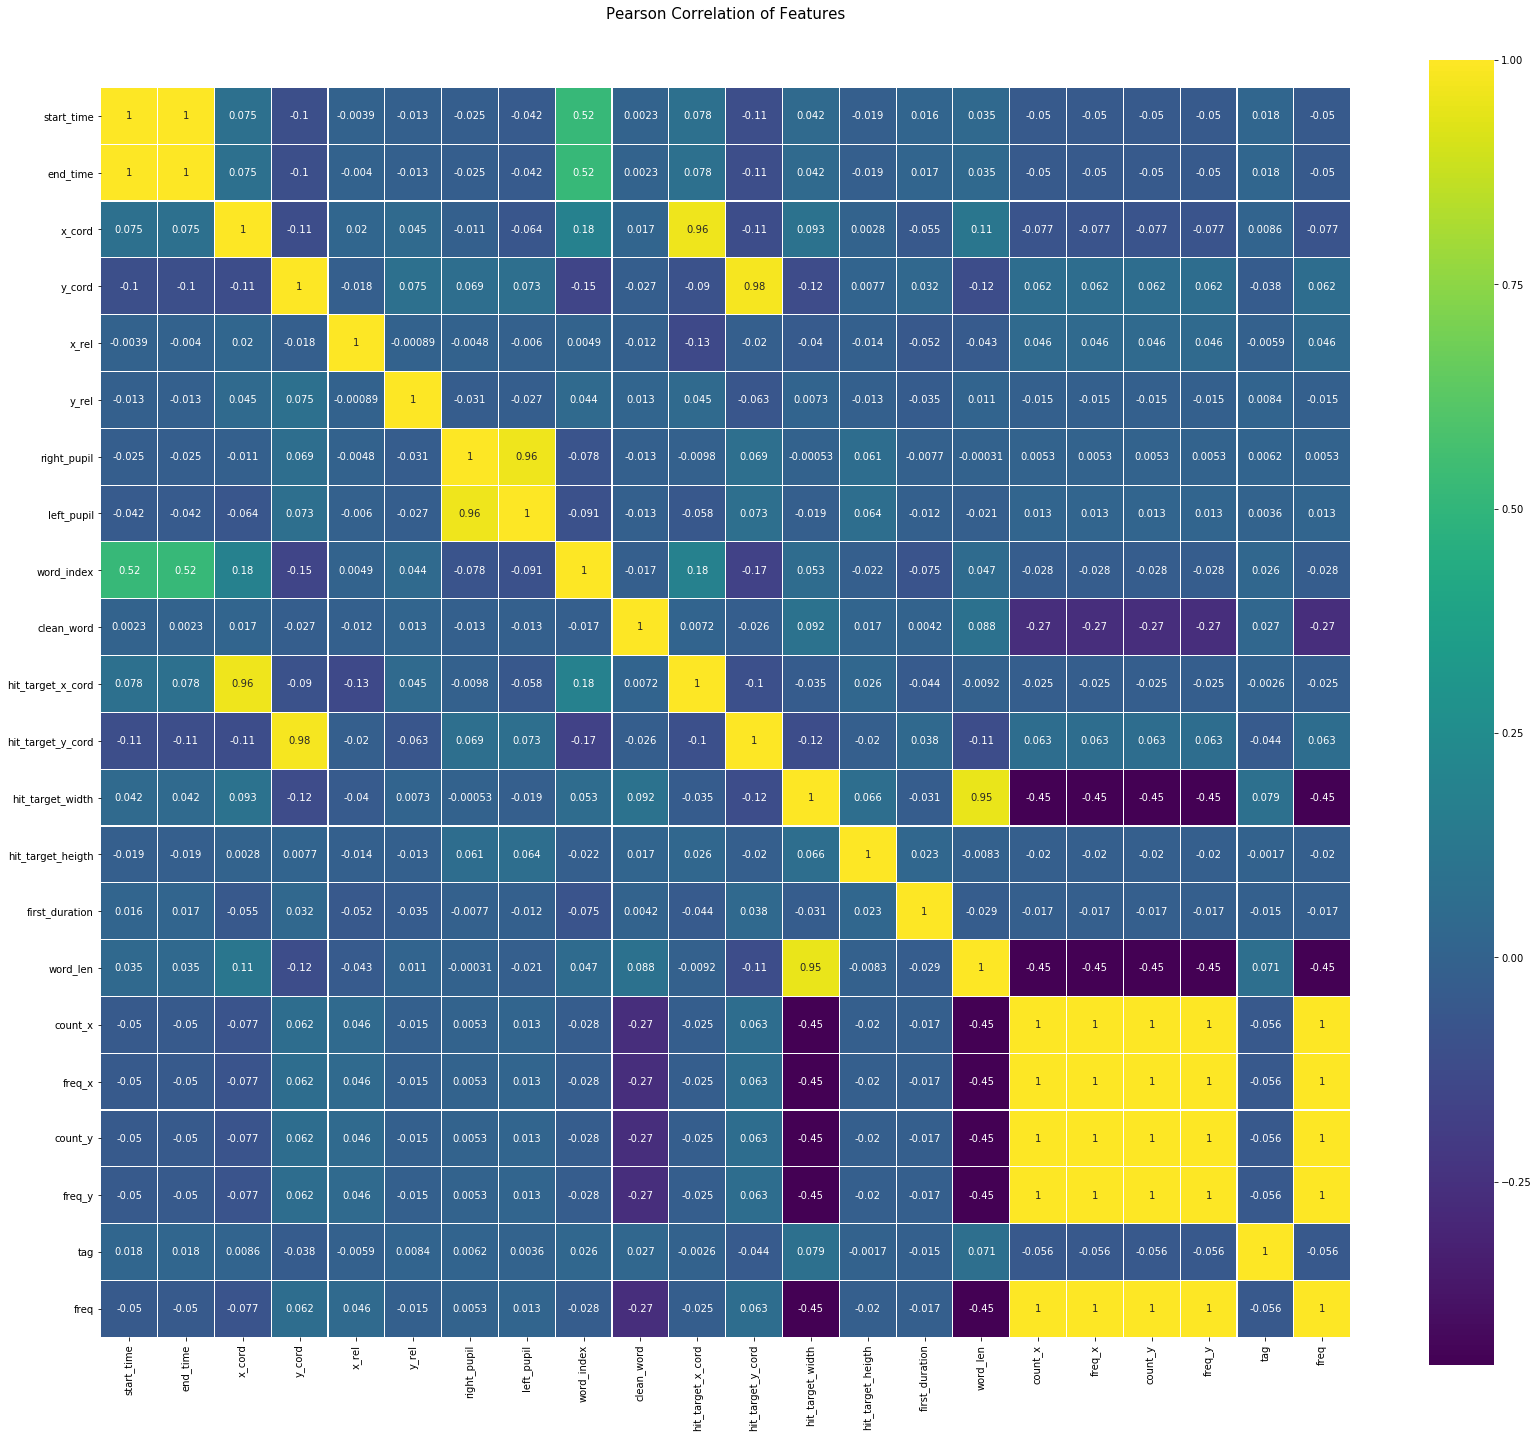

In [0]:
#Features correlation matrix
colormap = plt.cm.viridis
plt.figure(figsize=(28, 24))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(datafinal.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

We can visualize the ammount of *marked_misread* per user to understand the distriution per user within the dataset.

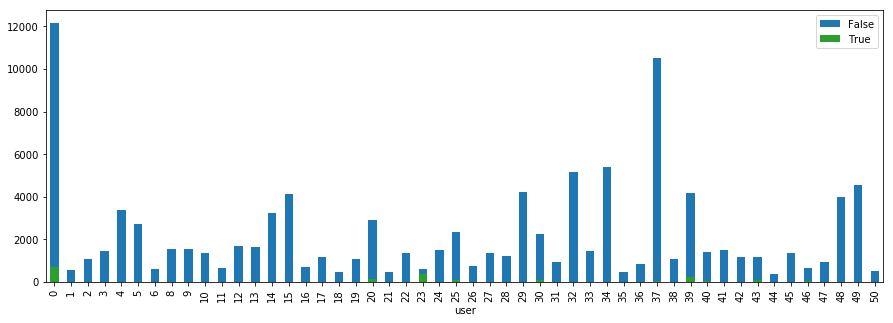

In [0]:
#Misreads per user
plt.rc('figure', figsize=(15, 5))

avg_misread = pd.crosstab(datahitword['user'], columns = datahitword['marked_misread'])
avg_misread['user'] = avg_misread.index

ax = avg_misread.plot(x = 'user', y = False, kind = 'bar')
avg_misread.plot(x = 'user', y = True, kind="bar", ax = ax, color = "C2")

plt.show()

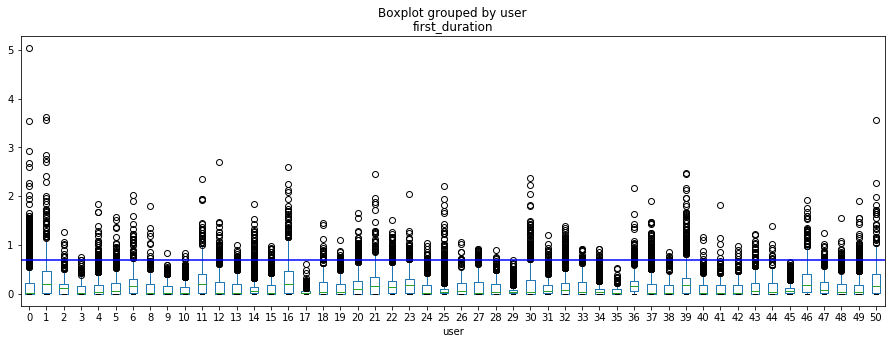

In [0]:
#Fix duration per word (boxplot)
dur_per_word = datahitword[['user', 'first_duration']]
dur_per_word.boxplot(column = 'first_duration', by = 'user').grid(False)
mean = datahitword['first_duration'].mean()
sd = np.std(datahitword['first_duration'])
z = mean + 3 * sd
plt.axhline( y= z, color='b', linestyle='-')
plt.show()

It seems that user 0 has the most *false* on marked_misread, but is also the user with the most variation on fix duration.

# Task 5 - Classification

### Classifiers

- Random Forest: Is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

- KMeans: Is an algorithm that clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares.

- Logistic Regression: Is a regression model where the dependent variable is categorical.

These classifiers were chosen due to the nature of the response variable (binary) and the problem (classification).

### Model Metrics

In this section various machine learning algorithms are tried to fit the best model for the dataset. The different models are compared through 2 metrics: **accuracy**, **F1 score** and **AUC score**.

- Accuracy: The set of labels predicted for a sample must exactly match the corresponding set of test labels.

- AUC Score: Computes Area Under the Curve (AUC) from prediction scores.

- F1 Score: Is a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

## Simple model with raw data

In [0]:
#Defining response variable and features
datafinal['any_misread'] = datafinal['any_misread'] * 1
y1 = datafinal['marked_misread']
X1 = datafinal[['start_time', 'end_time', 'x_cord', 'y_cord', 'x_rel', 'y_rel',
       'right_pupil', 'left_pupil', 'word_index', 'clean_word',
       'any_misread', 'hit_target_x_cord',
       'hit_target_y_cord', 'hit_target_width', 'hit_target_heigth']]

labelencoder_y1 = LabelEncoder()
y1 = labelencoder_y1.fit_transform(y1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.20, random_state = 0)

In [0]:
#Random Forest (default parameters)
rf1 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf1.fit(X_train1, y_train1)
rf_pred1 = rf1.predict(X_test1)
rf_score1 = accuracy_score(y_test1, rf_pred1)
rf_f1_score1 = f1_score(y_test1, rf_pred1, average='macro')

In [0]:
print('Random Forest Accuracy:', rf_score1)
print('Random Forest F1 Score:', rf_f1_score1)

Random Forest Accuracy: 0.997555661831
Random Forest F1 Score: 0.965354070661


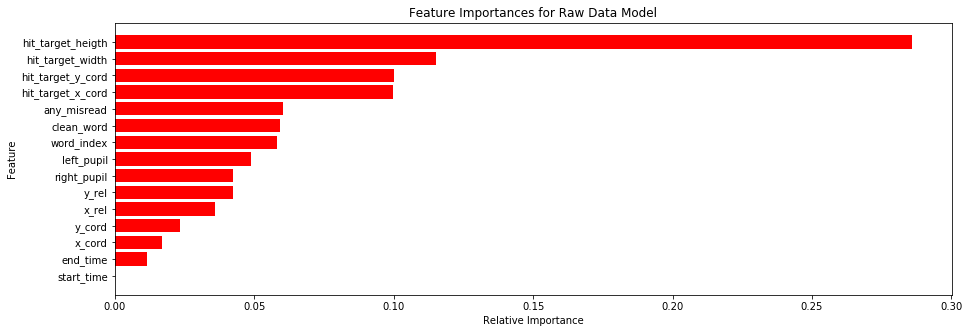

In [0]:
#Features importance for the best model (Random Forest)
features = X1.columns
importances = rf1.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances for Raw Data Model')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

The raw data model seems to have a very good fit on the data with a high accuracy and f1 score.

## Models with feature-engineered data

For modeling, we are spliting the dataset into training and test sets by and 80-20% ratio, and assigning the proper variables into responses and features.

In [0]:
#Defining response variable and features
datafinal['any_misread'] = datafinal['any_misread'] * 1
y = datafinal['marked_misread']
X = datafinal[['start_time', 'end_time', 'x_cord', 'y_cord', 'x_rel', 'y_rel',
       'right_pupil', 'left_pupil', 'word_index', 'clean_word',
       'any_misread', 'hit_target_x_cord',
       'hit_target_y_cord', 'hit_target_width', 'hit_target_heigth',
       'is_dupes', 'first_duration', 'word_len', 'freq', 'tag']]

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)

#Dataset Split into 80 / 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Unsupervised learning

Unsupervised machine learning is the machine learning task of inferring a function to describe hidden structure from *unlabeled* data (a classification or categorization is not included in the observations). 

In [0]:
#Kmeans Clustering (default parameters)
kmeans = KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(X_train)
kmeans_pred = kmeans.predict(X_test)
kmeans_score = accuracy_score(y_test, kmeans_pred)
kmeans_f1_score = f1_score(y_test, kmeans_pred, average='macro')
kmeans_auc_score = roc_auc_score(y_test, kmeans_pred, average='macro')

In [0]:
print('KMeans Accuracy:', kmeans_score)
print('KMeans F1 Score:', kmeans_f1_score)
print('KMeans AUC Score:', kmeans_auc_score)

KMeans Accuracy: 0.525957808598
KMeans F1 Score: 0.363386554379
KMeans AUC Score: 0.53156511046


### Supervised learning

Supervised learning is the machine learning task of inferring a function from labeled training data.

In [0]:
#logistic Regression
log_reg = LogisticRegression(random_state = 0)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_score = accuracy_score(y_test, log_reg_pred)
log_reg_f1_score = f1_score(y_test, log_reg_pred, average='macro')
log_reg_auc_score = roc_auc_score(y_test, log_reg_pred, average='macro')

#Random Forest (default parameters)
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_score = accuracy_score(y_test, rf_pred)
rf_f1_score = f1_score(y_test, rf_pred, average='macro')
rf_auc_score = roc_auc_score(y_test, rf_pred, average='macro')

In [0]:
print('Logistic Regression Accuracy:', log_reg_score)
print('Logistic Regression F1 Score:', log_reg_f1_score)
print('Logistic Regression AUC Score:', log_reg_auc_score)

print('Random Forest Accuracy:', rf_score)
print('Random Forest F1 Score:', rf_f1_score)
print('Random Forest AUC Score:', rf_auc_score)

Logistic Regression Accuracy: 0.981933152665
Logistic Regression F1 Score: 0.574642201288
Logistic Regression AUC Score: 0.544023355862
Random Forest Accuracy: 0.997874488549
Random Forest F1 Score: 0.970219020518
Random Forest AUC Score: 0.945956290976


The different models' results show that the best performing algorithm is the **Random Forest** in terms of accuracy and f1 score.

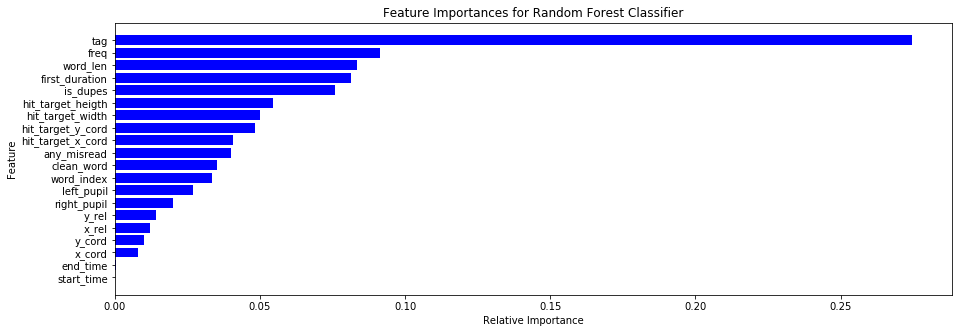

In [0]:
#Features importance for the best model (Random Forest)
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances for Random Forest Classifier')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

In [0]:
#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, rf_pred))
cm.columns = ['No', 'Yes']
cm.index.rename('No / Yes', inplace=True)
cm

,No,Yes
No / Yes,,
0,18457,1
1,39,322


The confusion matrix shows that the model misclassified 39 responses as not marked_misread and 1 response as marked_misread.

## Modeling with balanced data

In this section, to avoid a flawed analysis, the data is *balanced* by randomly choosing the same quantity of observations for *marked_misread* for both levels: *True* and *False*.
The *False* portion is being subsetted to match its dimension to the *True* portion.

In [0]:
databalt = datafinal[datafinal['marked_misread'] == True]
databalf = datafinal[datafinal['marked_misread'] == False]
databalf = databalf.sample(frac = 0.0193)
fr = [databalt, databalf]
databal = pd.concat(fr)

In [0]:
databal.groupby('marked_misread').count()

,start_time,end_time,x_cord,y_cord,x_rel,y_rel,right_pupil,left_pupil,word_index,clean_word,...,first_duration,word_len,count_x,freq_x,pos_tag,count_y,freq_y,word_tag,tag,freq
marked_misread,,,,,,,,,,,,,,,,,,,,,
False,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782,...,1782,1782,1782,1782,1782,1782,1782,1782,1782,1782
True,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779,...,1779,1779,1779,1779,1779,1779,1779,1779,1779,1779


### Supervised learning

In [0]:
#Defining response variable and features
databal['any_misread'] = datafinal['any_misread'] * 1
yb = databal['marked_misread']
Xb = databal[['start_time', 'end_time', 'x_cord', 'y_cord', 'x_rel', 'y_rel',
       'right_pupil', 'left_pupil', 'word_index', 'clean_word',
       'any_misread', 'hit_target_x_cord',
       'hit_target_y_cord', 'hit_target_width', 'hit_target_heigth',
       'is_dupes', 'first_duration', 'word_len', 'freq', 'tag']]

labelencoder_yb = LabelEncoder()
yb = labelencoder_yb.fit_transform(yb)

X_trainb, X_testb, y_trainb, y_testb = train_test_split(Xb, yb, test_size = 0.20, random_state = 0)

In [0]:
#Random Forest
rfb = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rfb.fit(X_trainb, y_trainb)
rf_predb = rfb.predict(X_testb)
rf_scoreb = accuracy_score(y_testb, rf_predb)
rf_f1_scoreb = f1_score(y_testb, rf_predb, average='macro')
rf_auc_scoreb = roc_auc_score(y_testb, rf_predb, average='macro')

In [0]:
print('Random Forest Accuracy:', rf_scoreb)
print('Random Forest F1 Score:', rf_f1_scoreb)
print('Random Forest AUC Score:', rf_auc_scoreb)

Random Forest Accuracy: 0.984572230014
Random Forest F1 Score: 0.984560081422
Random Forest AUC Score: 0.984417802828


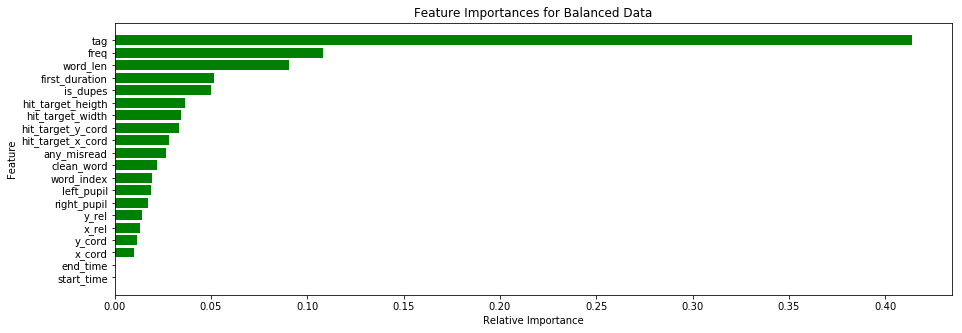

In [0]:
#Features importance for the best model (Random Forest)
features = Xb.columns
importances = rfb.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances for Balanced Data')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.ylabel('Feature')
plt.show()

In [0]:
cmb = pd.DataFrame(confusion_matrix(y_testb, rf_predb))
cmb.columns = ['No', 'Yes']
cmb.index.rename('No / Yes', inplace=True)
cmb

,No,Yes
No / Yes,,
0,341,8
1,3,361


The confusion matrix shows that the model misclassified 3 responses as not marked_misread and 23 response as marked_misread.

There doesn't seem to be a significant difference in the results of the balanced and unbalanced data. This shows that the models created provide a good representation of how the dataset behaves.

# Task 6 - Conclusions

The data unbalance posts a major skepticism to wether the results are viable for a practical application or not. Even if the results from balanced and unbalanced models yielded high accuracy scores.

The simple model yielded high accuracy scores. This is probably because the features presented were already sufficient to perform a satisfactory prediction.

The chosen machine learning classification algorithms showed satisfactory performance. This shows that the presented models were capable of identifying the general pattern of the data and provide a high accuracy prediction.

- The tag (type of word) in the books is the feature that describes most of the variation of the data followed by word frequency, word length, first duration, and if the word is repeated in a sequence.


- The feature engineering efforts yielded little improvement in the model's performance (from **97.02%** to **98.46%**), meaning that the extra extracted features were significant, but described the same variation in the dataset as the initial ones.


- There is not a significant difference in model performance between balanced and unbalanced datasets: **99.79%** (unbalanced) vs **98.46%** (balanced).

Further work could be done to improve the current models:

- Try a neural network classification algorithm on the data
- Produce more features from the data for modeling
- Obtain balanced dataset